# Export LangSmith Dataset tests and aggregate by metadata

The goal is to generate plots aggregating result sets from a specific dataset and aggregate the result over-time by a pre-defined project metadata key.

In [1]:
!pip install langsmith matplotlib

In [2]:
from getpass import getpass
import os
os.environ["LANGCHAIN_API_KEY"] = getpass("LangSmith API Key: ")
dataset_name = input("Dataset name: ")
metadata_key = input("Project metadata key: ")

LangSmith API Key:  ········
Dataset name:  ragstack-ci-rag-custom-chain
Project metadata key:  llm


In [20]:
import os
import dataclasses
import datetime

from dataclasses import dataclass
from typing import List
from langsmith import Client

@dataclass
class RunStats:
    run_id: str
    error: bool
    ts: datetime
    latency: float
    total_tokens: int
    feedbacks: dict[str, float]

use_existing = ""

client = Client()
examples = client.list_examples(dataset_name=dataset_name)
examples = list(examples)
print(f"Found {len(examples)} examples")

runs_by_key = {}
feedback_set = []
for example in examples:
    print(f"Start fetching runs for example {example}")

    runs = client.list_runs(reference_example_id=example.id)
    runs = list(runs)
    for run in runs:
        trace = client.list_runs(run_ids=[run.trace_id])
        ts = 0
        latency = -1
        total_tokens = -1
        feedbacks = {}
        error = False

        for t in trace:
            latency = t.end_time - t.start_time
            ts = t.end_time
            latency = latency.total_seconds()
            total_tokens = t.total_tokens
            for f in client.list_feedback(run_ids=[t.id]):
                feedbacks[f.key] = f.score
                feedback_set.append(f.key)
            if t.error is not None:
                error = True
            break

        pro = client.read_project(project_id=run.session_id)
        key = pro.extra.get("metadata", {}).get(metadata_key, "")
        if key not in runs_by_key:
            runs_by_key[key] = []
        runs_by_key[key].append(RunStats(run_id=run.id, error=error, ts=ts, latency=latency, total_tokens=total_tokens, feedbacks=feedbacks))

print("Completed")
print(str(runs_by_key))

feedback_set = list(set(feedback_set))

Found 2 examples
Start fetching runs for example dataset_id=UUID('cb733917-efc5-4886-88dd-6974a7a62d28') inputs={'question': 'Could MyFakeProductForTesting helps me with bug resolution?'} outputs={'answer': 'Yes, MyFakeProductForTesting includes a bug detection module.'} id=UUID('1f369347-bd2f-4499-93fc-d28f5df44194') created_at=datetime.datetime(2024, 2, 19, 12, 22, 7, 941095, tzinfo=datetime.timezone.utc) modified_at=datetime.datetime(2024, 2, 19, 12, 22, 7, 941095, tzinfo=datetime.timezone.utc) runs=[] source_run_id=None
Start fetching runs for example dataset_id=UUID('cb733917-efc5-4886-88dd-6974a7a62d28') inputs={'question': 'When was released MyFakeProductForTesting for the first time ?'} outputs={'answer': 'MyFakeProductForTesting was released in June 2020'} id=UUID('b82eabfe-8718-45d8-ba3c-8cd7726a864c') created_at=datetime.datetime(2024, 2, 19, 12, 22, 5, 663947, tzinfo=datetime.timezone.utc) modified_at=datetime.datetime(2024, 2, 19, 12, 22, 5, 663947, tzinfo=datetime.timezon

"run_id","llm","latency","tokens","time","error","eval"
"90450087-5473-4cdb-b3b3-54235dafffac","ChatNVIDIA","2.829923","590","2024-02-20 09:29:26","0","{\"coherence\": 1.0, \"helpfulness\": 1.0, \"relevance\": 1.0, \"cot contextual accuracy\": 1.0, \"contextual accuracy\": 1.0}"
"d669f51a-1299-4169-a5da-eda2403619ca","ChatNVIDIA","3.024085","590","2024-02-20 09:27:37","0","{\"coherence\": 1.0, \"helpfulness\": 1.0, \"relevance\": 1.0, \"cot contextual accuracy\": 1.0, \"contextual accuracy\": 1.0}"
"c8477f87-b5b7-44b7-8f00-25221f681fed","ChatNVIDIA","3.690516","590","2024-02-20 09:07:45","0","{\"coherence\": 1.0, \"helpfulness\": 1.0, \"relevance\": 1.0, \"cot contextual accuracy\": 1.0, \"contextual accuracy\": 1.0}"
"1240cb5e-cef2-42f1-bbc3-319377c7ef9b","ChatNVIDIA","2.096276","590","2024-02-20 09:05:04","0","{\"coherence\": 1.0, \"helpfulness\": 1.0, \"relevance\": 1.0, \"cot contextual accuracy\": 1.0, \"contextual accuracy\": 1.0}"
"fa846f60-69ff-46fc-beda-ca7fb061c9a2","ChatNVID

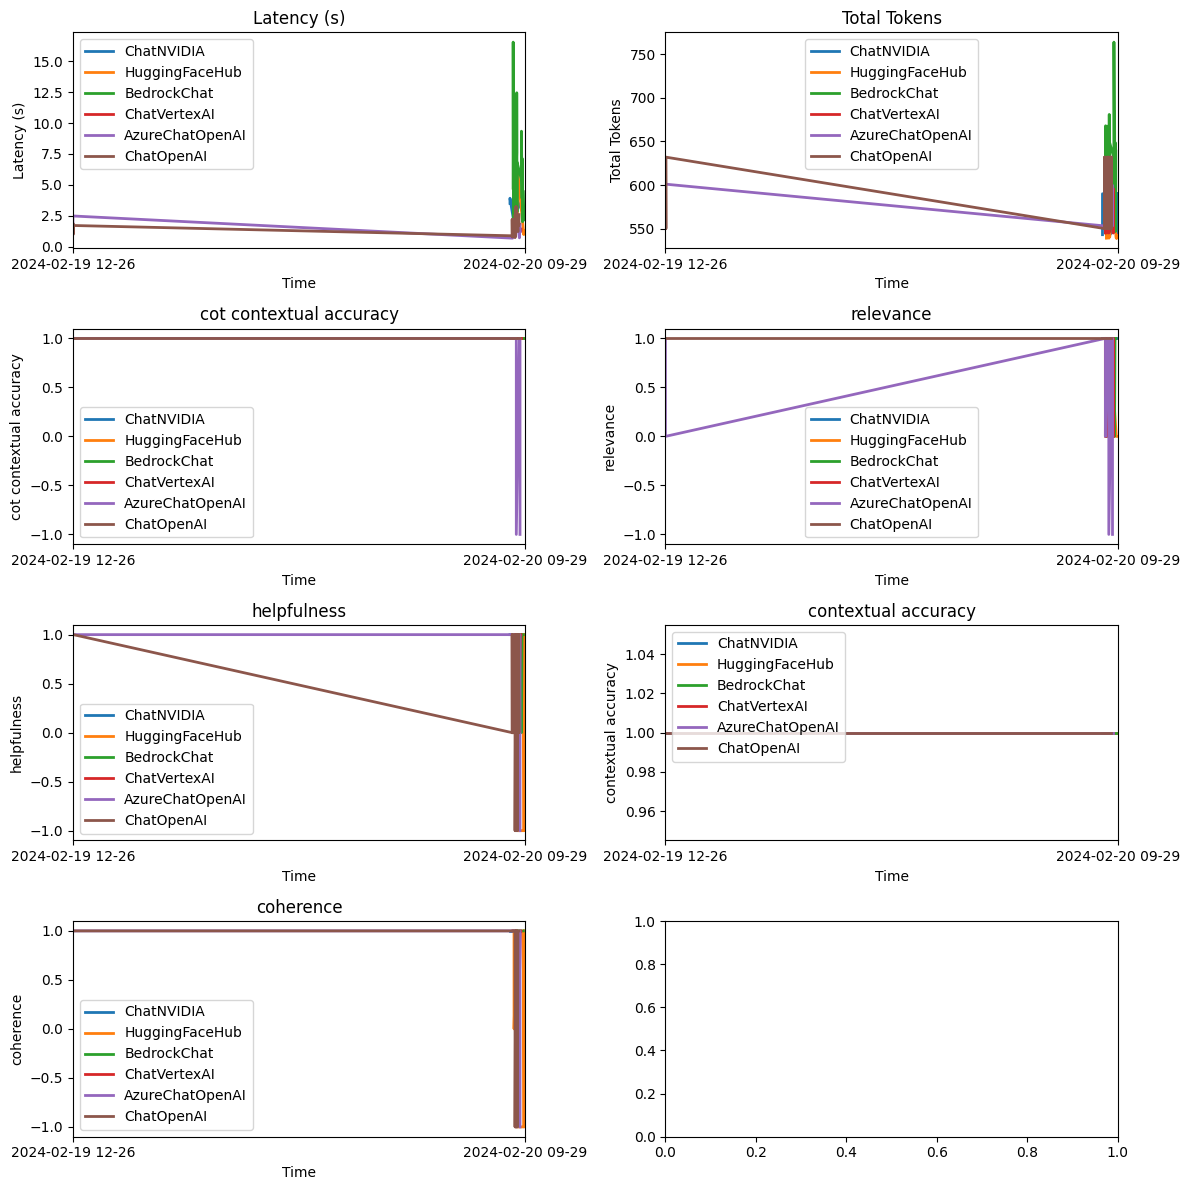

In [ ]:
import math
import json

with open('runs.csv', 'a') as file:
    file.write('"run_id","llm","latency","tokens","time","error","eval"\n')
    for llm in runs_by_key.keys():
        runs = runs_by_key[llm]
        for run in runs:
            err_str = "1" if run.error else "0"
            eval_str = json.dumps(run.feedbacks).replace('"', '\\\"')
            file.write(f"\"{run.run_id}\",\"{llm}\",\"{run.latency}\",\"{run.total_tokens}\",\"{run.ts.strftime('%Y-%m-%d %H:%M:%S')}\",\"{err_str}\",\"{eval_str}\"\n")



In [ ]:


import matplotlib.pyplot as main_plt

main_plt.rcParams["figure.figsize"] = (12, 12)
import matplotlib.dates as mdates
types = ["latency", "total_tokens"] + list(feedback_set)
fig, axs = main_plt.subplots(math.ceil(len(types) / 2), 2)
flat = axs.flat
for i, type in enumerate(types):
    plt = flat[i]
    min_ts = None
    max_ts = None
    for key in runs_by_key.keys():
        values = runs_by_key[key]
        values = sorted(values, key=lambda v: v.ts)
        if type == "latency":
            y = [run.latency for run in values]
        elif type == "total_tokens":
            y = [run.total_tokens for run in values]
        else:
            y = [(run.feedbacks[type] if type in run.feedbacks else -1) for run in values]            
        x = [run.ts for run in values]
        if min_ts is None:
            min_ts = min(x)
        else:
            min_ts = min(min(x), min_ts)
        if max_ts is None:
            max_ts = max(x)
        else:
            max_ts = max(max(x), max_ts)
        plt.plot(x, y, '-', lw=2, label=key)


    if type == "latency":
        ylabel = "Latency (s)"
    elif type == "total_tokens":
        ylabel = "Total Tokens"
    else:
        ylabel = type
    plt.set(xlabel="Time", ylabel=ylabel, title=ylabel)
    min_ts = min_ts
    max_ts = max_ts
    
    plt.set_xlim([min_ts, max_ts])
    plt.set_xticks([min_ts, max_ts])
    
    plt.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H-%M'))
    plt.legend()

fig.tight_layout()
main_plt.show()